## Comparing with to across subject variability

In [1]:
import numpy as np
import scipy.stats as stats
import nibabel.freesurfer.mghformat as mgh
import h5py

import sys

sys.path.append("..")

from paths import *
from constants import *

sys.path.append(CODE_PATH)

from utils.general_utils import make_iterable

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors as mcolors

In [4]:
import os 
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [60]:
def reject_outliers(data, m=2.):
    d = np.abs(data - np.mean(data))
    mdev = np.mean(d)
    s = d / (mdev if mdev else 1.)
    
    return data[s < m]

In [61]:
subjid = ["01", "02", "03", "04", "05", "06", "07", "08"]
roi = "streams_shrink10"
hemis = ["lh", "rh"]
mapping_func = "PLS"
CV = 0
subsample = 2
ROI_NAMES = ['Early',
             'Midventral',
             'Midlateral',
             'Midparietal',
             'Ventral',
             'Lateral',
             'Parietal']

source_roi = "streams_shrink20" 
num_splits = 5
n_source_voxels = 5000

In [62]:
means_nc = np.empty((len(subjid), len(ROI_NAMES)))
all_nc = [[[] for j in range(len(ROI_NAMES))] for i in range(len(subjid))]

means_s2s = np.empty((len(subjid), len(ROI_NAMES)))
all_s2s_rs = [[[] for j in range(len(ROI_NAMES))] for i in range(len(subjid))]

num_vox = np.zeros((len(hemis)))
for sidx, sid in enumerate(subjid):
    
    for hidx, hemi in enumerate(hemis):
        # Get ROI data
        mgh_file = mgh.load(
            NSDDATA_PATH
            + "freesurfer/subj"
            + sid
            + "/label/"
            + hemi
            + "."
            + roi
            + ".mgz"
        )
        streams = mgh_file.get_fdata()[:, 0, 0]
        num_vox[hidx] = streams[streams != 0].shape[0]
        if hidx > 0:
            streams_trim = np.append(streams_trim, streams[streams != 0])
        else:
            streams_trim = streams[streams != 0]

        # Get noise ceiling estimates
        mgh_file = mgh.load(
            stem
            + "/data/nsddata_betas/ppdata/subj"
            + sid
            + "/nativesurface/betas_fithrf_GLMdenoise_RR/"
            + hemi
            + ".nc_3trials.mgh"
        )
        NC = mgh_file.get_fdata()[:, 0, 0]
        if hidx > 0:
            NC_trim = np.append(NC_trim, NC[streams != 0])
        else:
            NC_trim = NC[streams != 0]
        

        # Get subject 2 subject mapping estimates
        load_path = (RESULTS_PATH
                    + "fits/subj2subj/subj"
                    + sid
                    + "_"
                    + hemi
                    + "_"
                    + source_roi
                    + "_to_"
                    + roi
                    + "_"
                    + str(num_splits)
                    + "splits_"
                    + "_subsample_"
                    + str(n_source_voxels if n_source_voxels is not None else 0)
                    + "voxels.hdf5")
        rsquared_array = {}
        with h5py.File(load_path, "r") as f:
            keys = f.keys()
            for k in keys:
                rsquared_array[k] = f[k][:]
        rs_by_layer = np.zeros((len(ROI_NAMES), int(num_vox[hidx])))
        for lix, layer in enumerate(ROI_NAMES):
            rs_by_layer[lix,:] = rsquared_array[layer] #reshape dict to array
        if hidx > 0:
            max_rs_s2s = np.append(max_rs_s2s, np.amax(rs_by_layer, axis=0))
        else:
            max_rs_s2s = np.amax(rs_by_layer, axis=0)
        
    for r in range(len(ROI_NAMES)):
        all_nc[sidx][r] = NC_trim[streams_trim==r+1]/100
        means_nc[sidx, r] = np.mean(NC_trim[streams_trim==r+1]/100)
        
    for r in range(len(ROI_NAMES)):
        all_s2s_rs[sidx][r] = max_rs_s2s[streams_trim==r+1]
        means_s2s[sidx,r] =  np.mean(max_rs_s2s[streams_trim==r+1])

    

No handles with labels found to put in legend.


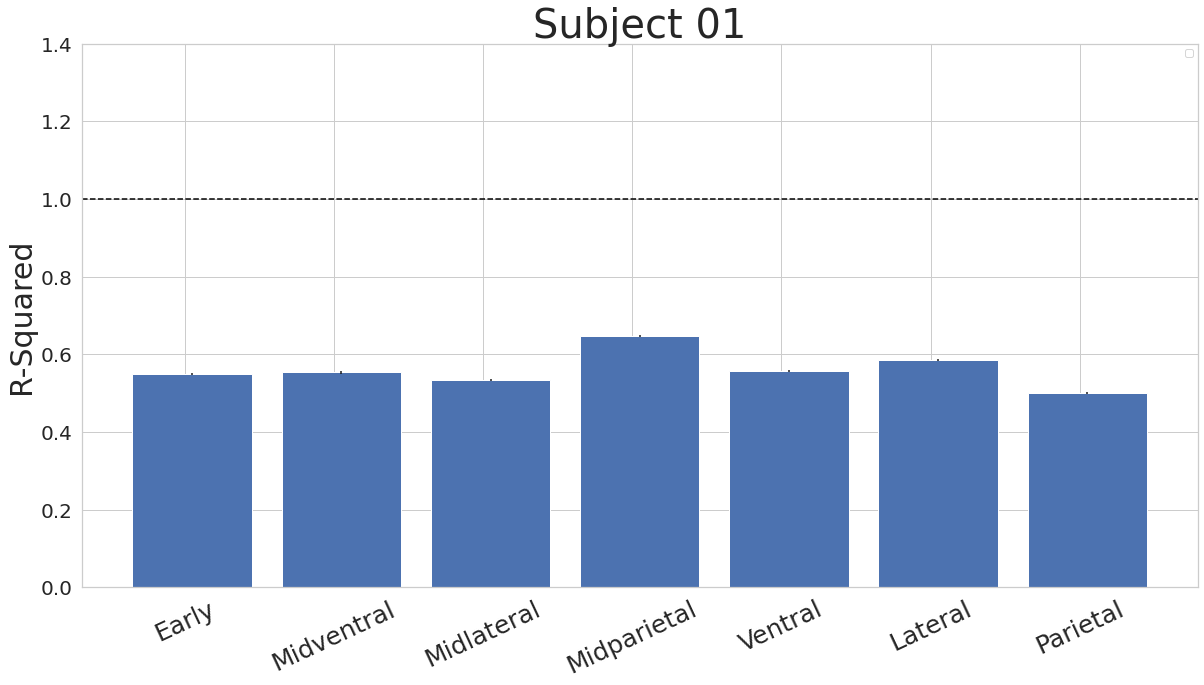

No handles with labels found to put in legend.


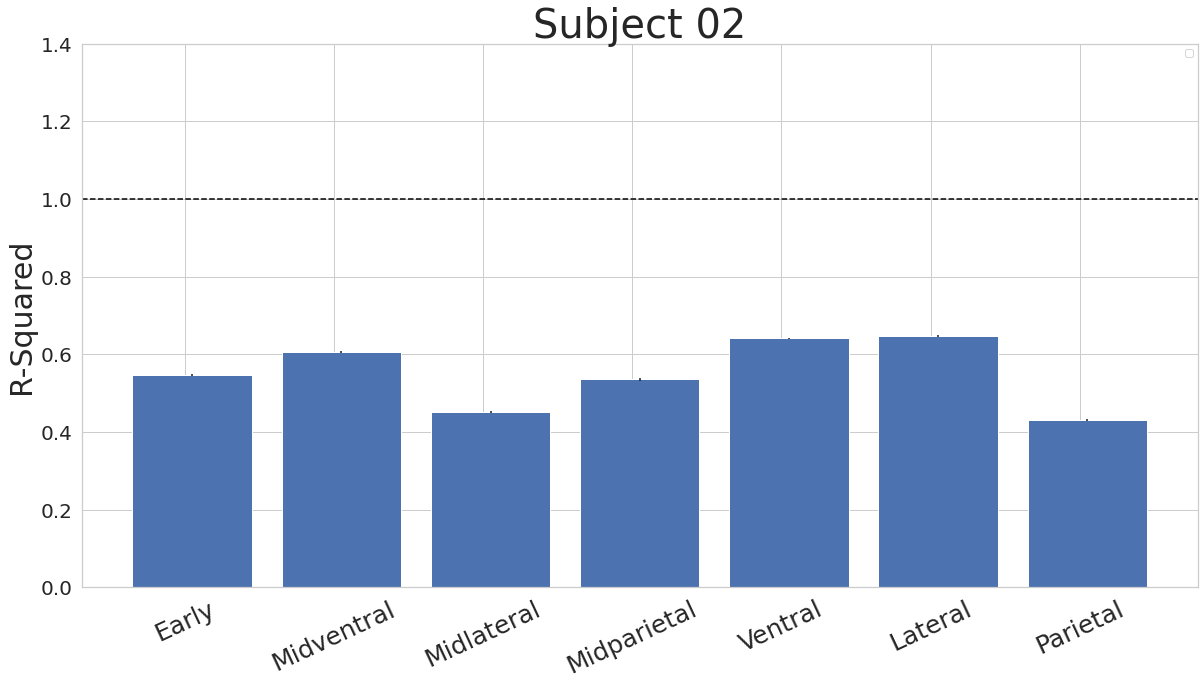

<ipython-input-63-1e7b7abf0e27>:14: RuntimeWarning: divide by zero encountered in true_divide
  corrected_medians[sidx][r] = np.median(all_s2s_rs[sidx][r]/all_nc[sidx][r])
<ipython-input-63-1e7b7abf0e27>:16: RuntimeWarning: divide by zero encountered in true_divide
  data = [np.median(all_s2s_rs[sidx][r]/all_nc[sidx][r]) for r in range(len(ROI_NAMES))]
<ipython-input-63-1e7b7abf0e27>:17: RuntimeWarning: divide by zero encountered in true_divide
  error = [stats.sem(all_s2s_rs[sidx][r]/all_nc[sidx][r]) for r in range(len(ROI_NAMES))]
/share/kalanit/users/dfinzi/fit_venv/lib/python3.8/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
No handles with labels found to put in legend.


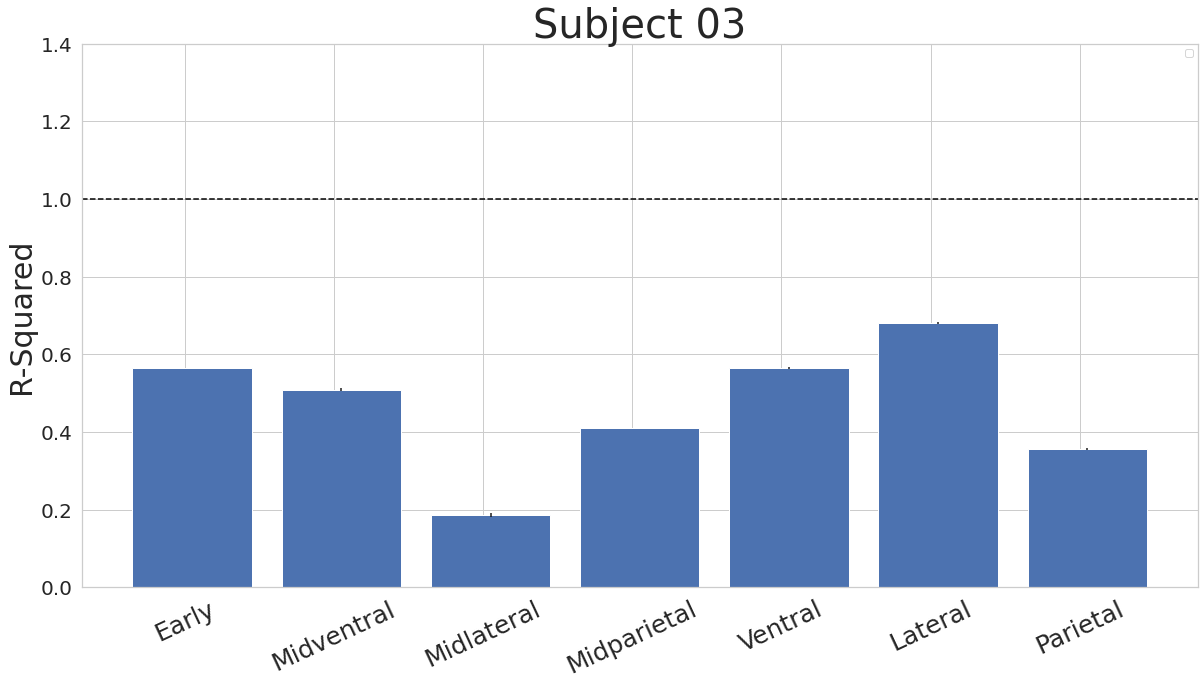

No handles with labels found to put in legend.


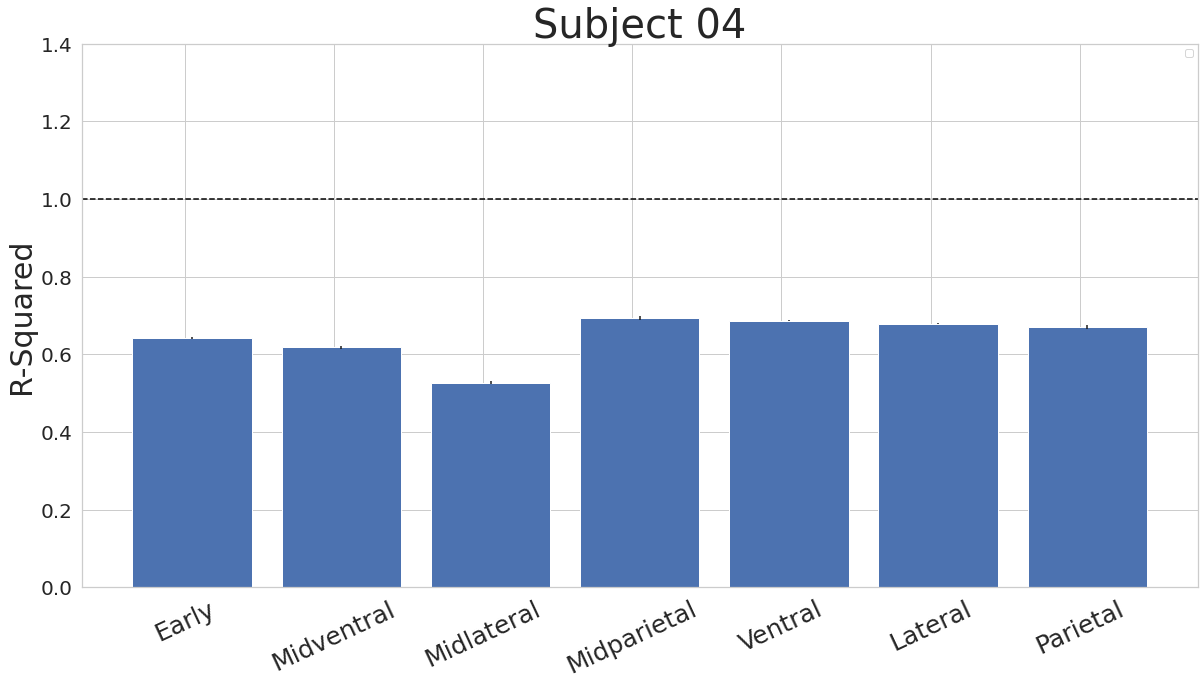

No handles with labels found to put in legend.


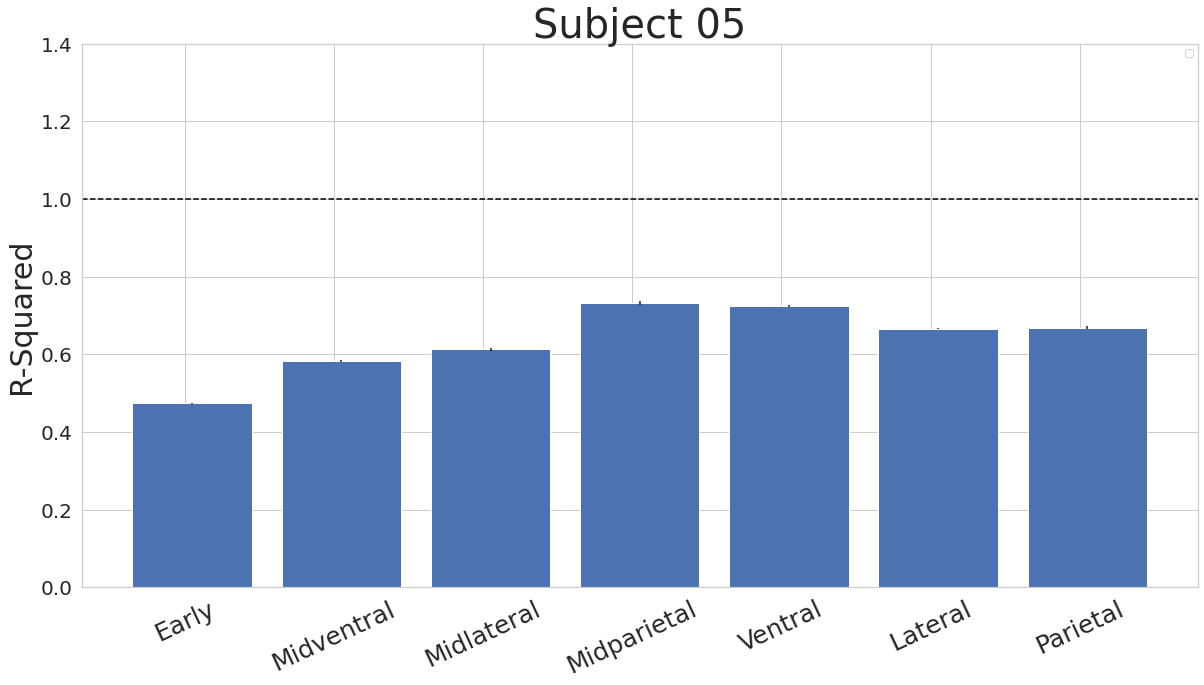

No handles with labels found to put in legend.


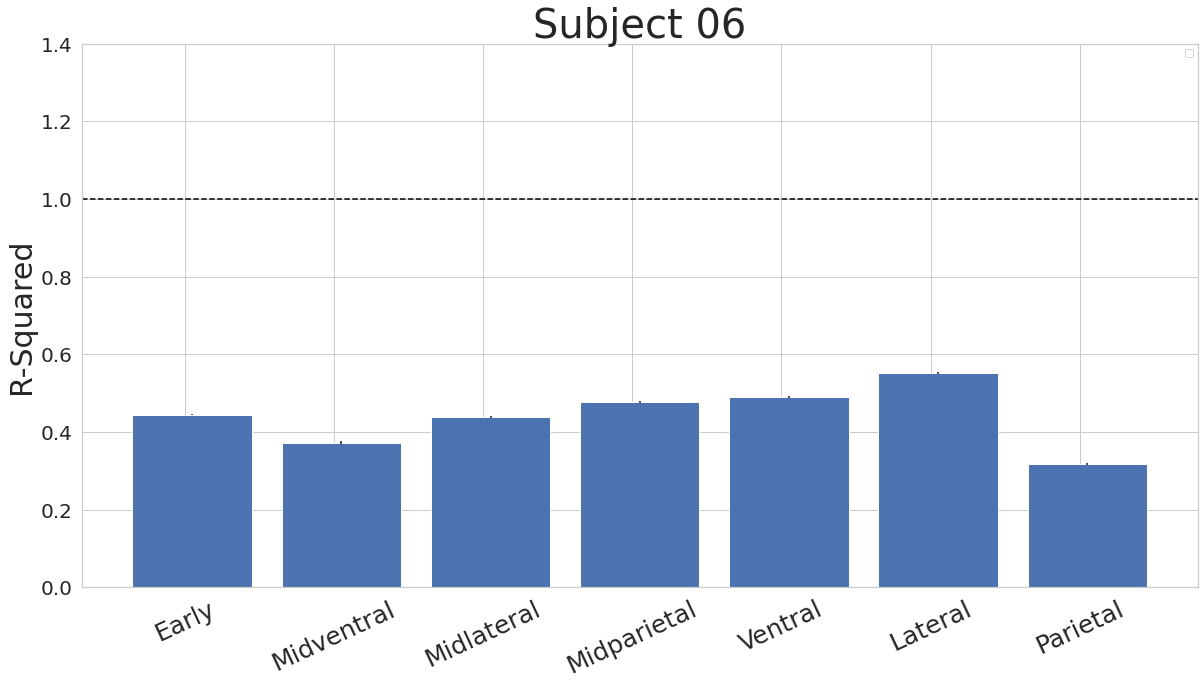

No handles with labels found to put in legend.


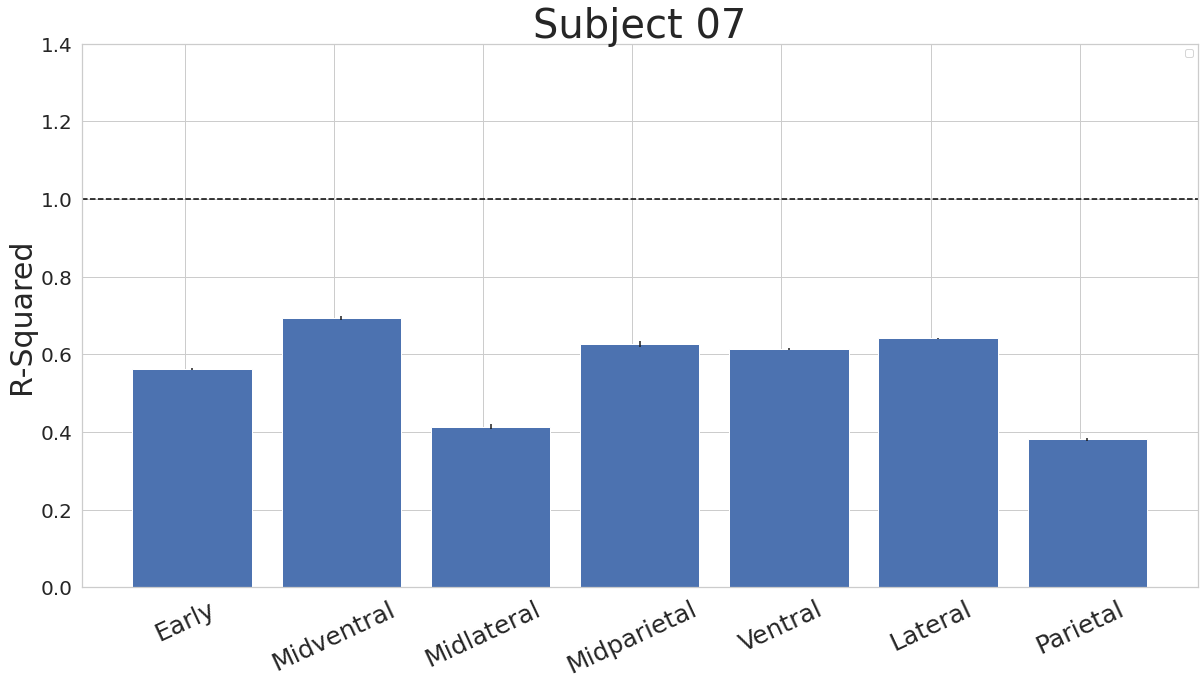

/share/kalanit/users/dfinzi/fit_venv/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)
No handles with labels found to put in legend.


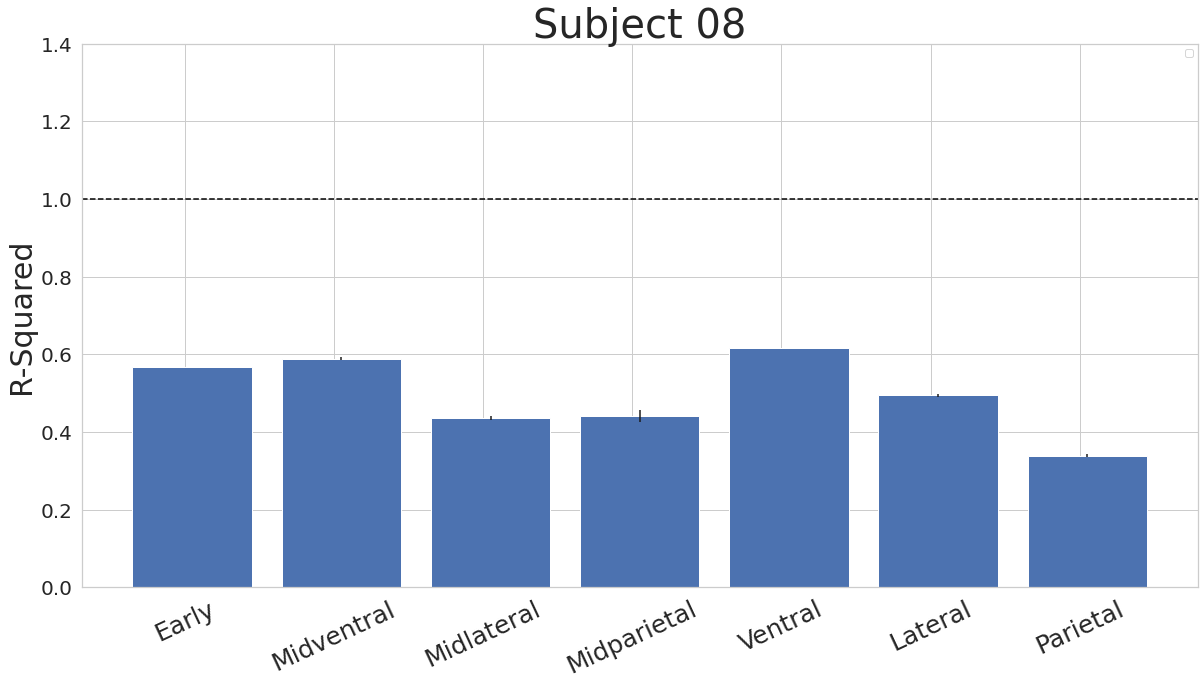

In [63]:
corrected_medians = np.empty((len(subjid), len(ROI_NAMES)))

cmap = matplotlib.cm.get_cmap('plasma')

for sidx, sid in enumerate(subjid):
    fig, ax = plt.subplots(figsize=(20, 10))
    fig.patch.set_facecolor('white')
    
    # set width of bars
    barWidth = 0.1
    
        
    for r in range(len(ROI_NAMES)):
        corrected_medians[sidx][r] = np.median(all_s2s_rs[sidx][r]/all_nc[sidx][r])

    data = [np.median(all_s2s_rs[sidx][r]/all_nc[sidx][r]) for r in range(len(ROI_NAMES))]
    error = [stats.sem(all_s2s_rs[sidx][r]/all_nc[sidx][r]) for r in range(len(ROI_NAMES))]

    plt.bar(range(len(ROI_NAMES)), data, yerr=error, edgecolor='white')
        
    plt.axhline(y = 1, xmin = 0, xmax = 1, color = 'black', linestyle='dashed')
    plt.xticks([r - barWidth/2 for r in range(len(data))], ROI_NAMES, rotation=25, fontsize=25);

    plt.ylabel('R-Squared',size = 30)
    plt.yticks(fontsize=20)
    
    plt.ylim([0, 1.4])

    title_string = "Subject "
    title_string += sid
    plt.title(title_string,size = 40)

    # Create legend & Show graphic
    plt.legend(fontsize=10)

    save_path = (RESULTS_PATH 
                + "fits/figures/subj"
                + sid
                + "_both_"
                + roi
                + "_PCA_fitcomp_bymodel_norm_by_s2s.png")

    #fig.savefig(save_path)
    plt.show()



### Experimenting with pandas and seaborn

In [64]:
d = {
    'subject_name': np.concatenate((np.tile('subj01',len(ROI_NAMES)), 
                                    np.tile('subj02',len(ROI_NAMES)), 
                                    np.tile('subj03',len(ROI_NAMES)),
                                    np.tile('subj04',len(ROI_NAMES)),
                                    np.tile('subj05',len(ROI_NAMES)),
                                    np.tile('subj06',len(ROI_NAMES)),
                                    np.tile('subj07',len(ROI_NAMES)),
                                    np.tile('subj08',len(ROI_NAMES)))),
    'roi': np.tile(ROI_NAMES, len(subjid)),
    'corrected': corrected_medians.ravel(),
    
}

In [65]:
print(len(d['subject_name']))
print(len(d['roi']))
print(len(d['corrected']))


56
56
56


In [66]:
# Wanted palette details
roi_palette = ['#a6a6a6' , '#f4bdd8', '#ccdaff', '#b3ffc6',  '#DC267F' ,'#4d7fff','#006600']
color_codes_wanted = ROI_NAMES
cdict = dict(zip(color_codes_wanted, [mcolors.to_rgba(c) for c in roi_palette]))
#cdict = dict(zip(models, rgba))
#
mcolors.get_named_colors_mapping().update(cdict)
#
#model_colors=np.ravel([np.tile(m, len(ROI_NAMES)) for m in models])

In [28]:
cdict

{'Early': (0.6509803921568628, 0.6509803921568628, 0.6509803921568628, 1.0),
 'Midventral': (0.9568627450980393,
  0.7411764705882353,
  0.8470588235294118,
  1.0),
 'Midlateral': (0.8, 0.8549019607843137, 1.0, 1.0),
 'Midparietal': (0.7019607843137254, 1.0, 0.7764705882352941, 1.0),
 'Ventral': (0.8627450980392157, 0.14901960784313725, 0.4980392156862745, 1.0),
 'Lateral': (0.30196078431372547, 0.4980392156862745, 1.0, 1.0),
 'Parietal': (0.0, 0.4, 0.0, 1.0)}

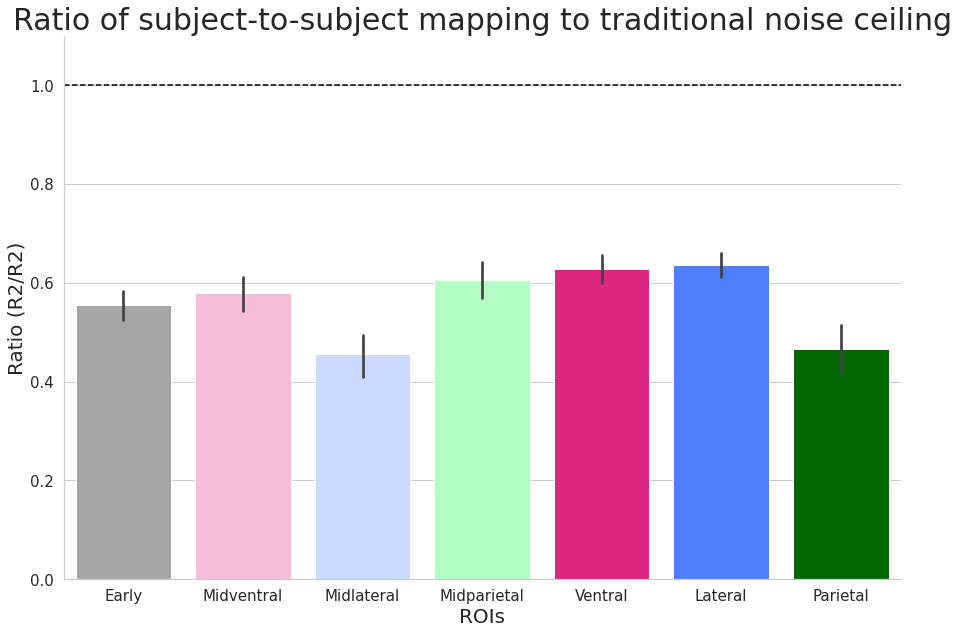

In [68]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(x="roi", y="corrected", palette='cool_r',data=df, ci=68, ax=ax)

for idx, bar in enumerate(ax.patches):
    bar.set_color(cdict[ROI_NAMES[idx]])
    bar.set_edgecolor("w")
    
# iterate over range of number of rows    
ax.set_xlabel('ROIs', fontsize=20)
ax.set_ylabel('Ratio (R2/R2)', fontsize=20)
ax.tick_params(labelsize=15)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.title('Ratio of subject-to-subject mapping to traditional noise ceiling',size = 30)
plt.ylim([0, 1.1])

ax.axhline(y = 1, xmin = 0, xmax = 1, color = 'black', linestyle='dashed')

save_path = (RESULTS_PATH 
                + "fits/figures/groupavg_both_"
                + roi
                + "_s2s_fits_norm_by_trad_nc.png")

fig.savefig(save_path)
